In [ ]:
# load Google Driver files (optional)
# from google.colab import drive
# drive.mount('/content/drive')

# !IMPORTANT INFORMATION!
# please check wheather import or install the Python packages below

In [47]:
import os
import math
import pandas as pd
import numpy as np
import tabulate
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import cv2
import pdb
import scipy
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
plt.rcParams['figure.dpi'] = 150 # setting the resolution of output figures

## a. Questions: 
> What is the feature of interest? Describe in detail how you selected the images based on the feature of interest and on features of no interest.

> answer: the mouth curve

# 4. Data pre-processing

## 4.a Load the data in your analysis environment of choice (Matlab, Python, ...)
1. if use Google colab, please use this follow line to import files:
   ```
   from google.colab import drive
   drive.mount('/content/drive')
   filename=r'/content/drive/Othercomputers/我的 MacBook Pro/Desktop/02458/results.txt'
   ```
2. if use local environmennt, please use this directory: 
   ```/Users/baixiang/Desktop/02458/results.csv```

### The columns in the dataset are:
- subject_id 
- trial_number
- stimulus_filename
- answer
- reaction_time

In [6]:
filename=r'/Users/baixiang/Desktop/02458/results.csv'
attributeNames = ['subject_id', 'trial_number', 'stimulus_filename', 'answer','reaction_time']
result = ['Not smiling','Smiling']
result_dits = [0, 1]
df = pd.read_csv(filename, names = attributeNames)
raw_data = df.values
# show DataFrame data, only 5 head items and 5 tail items
display(HTML('<h2>Show the first 5 rows of data (Pand DataFrame format)</h2>'),df.head(5)) 
display(HTML('<h2>Show the last 5 rows of data (Pand DataFrame format)</h2>' ),df.tail(5))
# show Numpy data, only first 10 rows
display(HTML('<h2>Show the first 10 rows of data (Numpy Ndarray format)</h2>' + tabulate.tabulate(raw_data[:9], 
              headers=attributeNames, showindex='always', tablefmt='html')))

,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,1,1,ARimage100.png,Not smiling,1.2788
1,1,2,ARimage56.png,Smiling,0.7123
2,1,3,ARimage188.png,Not smiling,0.6803
3,1,4,ARimage233.png,Not smiling,0.5367
4,1,5,ARimage276.png,Not smiling,0.7445


,subject_id,trial_number,stimulus_filename,answer,reaction_time
294,1,294,ARimage78.png,Not smiling,0.5510
295,1,295,ARimage57.png,Not smiling,0.5987
296,1,296,ARimage253.png,Smiling,0.5546
297,1,297,ARimage135.png,Smiling,0.4931
298,1,298,ARimage198.png,Not smiling,0.6050


,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,1,1,ARimage100.png,Not smiling,1.2788
1,1,2,ARimage56.png,Smiling,0.7123
2,1,3,ARimage188.png,Not smiling,0.6803
3,1,4,ARimage233.png,Not smiling,0.5367
4,1,5,ARimage276.png,Not smiling,0.7445
5,1,6,ARimage297.png,Not smiling,0.4844
6,1,7,ARimage43.png,Not smiling,0.4767
7,1,8,ARimage195.png,Not smiling,0.527
8,1,9,ARimage133.png,Not smiling,0.6204


## 4.b Consider removing outliers for the reaction time (above several seconds, below 200ms)
There are two method:
1. if values > μ + 3σ and values < μ—3σ, I suppose they are outliers
2. if values > 1s and values < 200ms, I suppose they are outliers (from the project instruction)

I choose the second one, cause it's seems really efficient

In [7]:
mean = raw_data[:,4].mean()                   # caluate the mean of the data we collected
std  = raw_data[:,4].std()                    # caluate the Standard deviation of the data we collected
subject_id = sorted(set(raw_data[:,0]))       # abstract the observer's ID
N = len(subject_id)                           # count the amount of observer involved in our experiment
# show all the data details
print('There are', N, 'observers in the train dataset')
print('And they are', subject_id)
print('The average reaction time of all the observers is', mean, 's, and the variance is', std)
# define the outlier threshod
upper_threshod, lower_threshod = 1, 0.2

'''clean the data, weed out outliers'''
X = []  # empty list to save the cleaned data
Outliers = 0   # counter of outliers
for i in range(len(raw_data[:,0])):
  if  lower_threshod < raw_data[i,4] < upper_threshod:
    X.append(raw_data[i])
  else:
    Outliers += 1
print('There are', Outliers, 'outliers in our data')

'''coding the face emotion results smelling and not smelling to digits'''
X = np.array(X)
for i in range(len(X[:,0])):
  if X[i,3] == 'Smiling':
    X[i,3] = 1
  else:
    X[i,3] = 0

'''show fist 10 rows of cleaned data X'''
display(HTML(tabulate.tabulate(X[:9], headers=attributeNames, showindex='always', tablefmt='html')))

There are 1 observers in the train dataset
And they are [1]
The average reaction time of all the observers is 0.5664903010033445 s, and the variance is 0.4019524969099586
There are 4 outliers in our data


,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,1,2,ARimage56.png,1,0.7123
1,1,3,ARimage188.png,0,0.6803
2,1,4,ARimage233.png,0,0.5367
3,1,5,ARimage276.png,0,0.7445
4,1,6,ARimage297.png,0,0.4844
5,1,7,ARimage43.png,0,0.4767
6,1,8,ARimage195.png,0,0.527
7,1,9,ARimage133.png,0,0.6204
8,1,10,ARimage248.png,0,0.4931


## 4.c Normalise the reaction times for each person and then pool them into one data set.
There are many kinds of normalise methods:
1. z = (x - u) / s
2. z = (x - u)

In [11]:
'''dynamicly assert series variables about each observers'''
names = {}
for i in range(N):
    names['observer' + str(i)] = []

'''split the raw data into obsever data respectively'''
for j in range(len(X[:,0])):
    for i in range(N):
        if X[j,0] == subject_id[i]:
            names['observer' + str(i)].append(X[j])

'''convert the list to numpy array and Normalization'''
for i in range(N):
    names['observer' + str(i)] = np.array(names['observer' + str(i)])
    observer_mean = names['observer' + str(i)][:,4].mean()
    observer_std = names['observer' + str(i)][:,4].std()
    names['observer' + str(i) + '_normal'] = ((names['observer' + str(i)][:,4]- observer_mean) / observer_std).flatten()
    print('The '+str(i+1)+'th observer\'s valid answers is',names['observer' + str(i) + '_normal'].shape)
    # print(names['observer' + str(i) + '_normal'].flatten())

The 1th observer's valid answers is (295,)


### plot the scatter of observers under given answer.
- From the figure, we can see that the observers generally recognize smiles quickly, indicating that humans are more sensitive respect to smelling

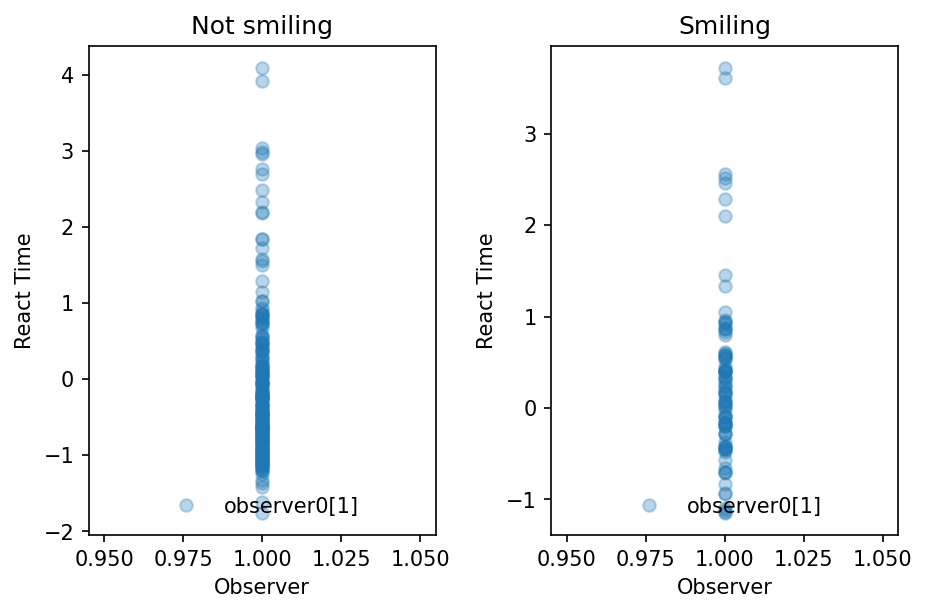

In [12]:
for c in result_dits:
    plt.subplot(1, 2, c+1)
    for i in range(N):
        # select indices belonging to class c:
        class_mask = names['observer' + str(i)][:,3]==c # range(len(names['observer' + str(i)][class_mask,0]))
        plt.plot([i+1 for j in names['observer' + str(i) + '_normal'][class_mask]], names['observer' + str(i) + '_normal'][class_mask], 'o', alpha=.3)
    plt.legend(['observer' + str(j) + '[' + str(subject_id[j]) + ']' for j in range(N)], frameon=False, loc='lower center')
    plt.title(result[c])
    plt.ylabel('React Time')
    plt.xlabel('Observer')
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

## 4.d Convert the binary answers and the reaction times to a continuous index
- the following code has already finished in the ```4.b``` part

In [13]:
'''coding the face emotion results smelling and not smelling to digits'''
X = np.array(X)
for i in range(len(X[:,0])):
    if X[i,3] == 'Smiling':
        X[i,3] = 1
    else:
        X[i,3] = 0

'''show fist 10 rows of cleaned data X'''
display(HTML(tabulate.tabulate(X[:9], headers=attributeNames, showindex='always', tablefmt='html')))

,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,1,2,ARimage56.png,0,0.7123
1,1,3,ARimage188.png,0,0.6803
2,1,4,ARimage233.png,0,0.5367
3,1,5,ARimage276.png,0,0.7445
4,1,6,ARimage297.png,0,0.4844
5,1,7,ARimage43.png,0,0.4767
6,1,8,ARimage195.png,0,0.527
7,1,9,ARimage133.png,0,0.6204
8,1,10,ARimage248.png,0,0.4931


## 4.e <b>Question</b>: 
> ### Explain every step of the conversion of the raw data to the continuous index. Plot a histogram of your index values.
<b>Answer</b>: 
> plot hisgram of each observers, we choose 20 span bins to display.

> It can be seen from the histogram that the reaction time of the observer is basically similar to a normal distribution

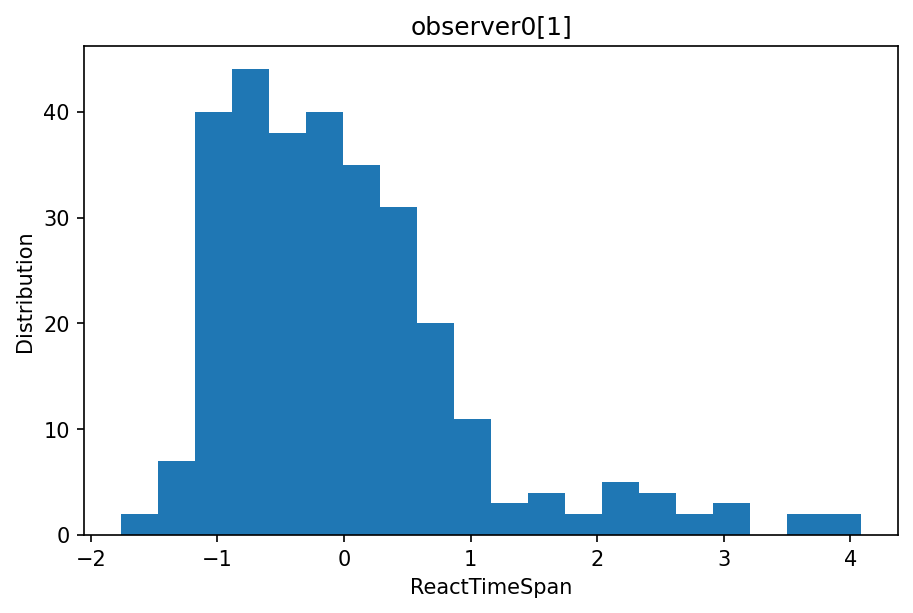

In [60]:
for i in range(N):
    plt.subplot(1, N, i+1)
    plt.hist(names['observer' + str(i) + '_normal'], bins=20)
    plt.title('observer' + str(i) + '[' + str(subject_id[i]) + ']')
    plt.xlabel('ReactTimeSpan')
    plt.ylabel('Distribution')
    plt.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)

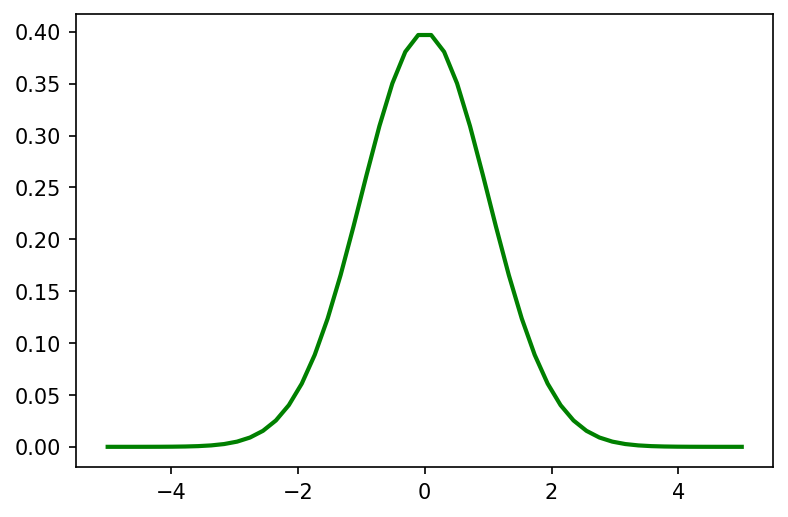

In [61]:
# plot a standard normal distribute
u = 0   # 均值μ
sig = 1  # 标准差δ
x = np.linspace(-5, 5)   # 定义域
y = np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2 * math.pi)*sig) # 定义曲线函数
plt.plot(x, y, "g", linewidth=2)    # 加载曲线

# 5. PCA and feature selection

## 5.a Subtract the mean image from all the images

The shape of ARArchive: (298, 1, 50, 50)  Type: <class 'numpy.ndarray'>
The shape of ARArchive: (298, 2500)  Type: <class 'numpy.ndarray'> (sequenced and normalized)


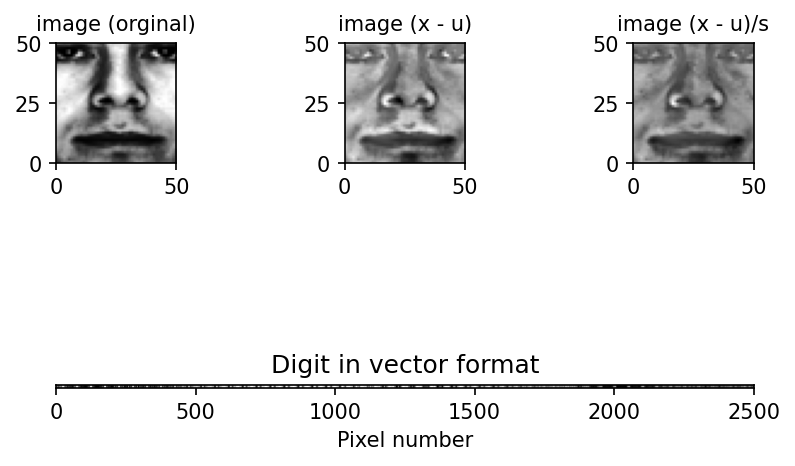

In [86]:
image_path = r'./ARArchive/'

ori_imgs = []
for f_name in os.listdir(image_path):
    if f_name == ".DS_Store":
        continue
    tmp_path = os.path.join(image_path,f_name)
    img = cv2.imread(tmp_path,-1).reshape(1,50,50)
    ori_imgs.append(img)
ori_imgs = np.array(ori_imgs)

'''sequence/flatten and normalize all the images in the dataset'''
N_pic, N_channel, highth, width = ori_imgs.shape # the original of picture number, channel number, highth, width
sequence_imgs = ori_imgs.reshape(-1, highth * width)
# Two ways to normalize our sequenced images
normal_imgs = sequence_imgs - sequence_imgs.mean(axis=0)
normal_std_imgs = (sequence_imgs - sequence_imgs.mean(axis=0)) / sequence_imgs.std(axis=0)

# show shape of the dataset [ARArchive]:
print('The shape of ARArchive:',ori_imgs.shape, ' Type:', type(ori_imgs))
print('The shape of ARArchive:',normal_imgs.shape, ' Type:', type(normal_imgs), '(sequenced and normalized)')

'''display any image in our dataset'''
i = np.random.randint(N_pic) # select an image randomly
f = plt.figure() 

# Visualize the i'th digit as an image
plt.subplot(2,5,1); # orginal image
plt.imshow(ori_imgs[i].reshape(50,50), extent=(0,50,0,50), cmap=plt.cm.gray);
plt.title('image (orginal)', fontsize = 10);
plt.subplot(2,5,3); #  mean image
plt.imshow(normal_imgs[i].reshape(50,50), extent=(0,50,0,50), cmap=plt.cm.gray);
plt.title('image (x - u)', fontsize = 10);
plt.subplot(2,5,5); #  mean and std image
plt.imshow(normal_std_imgs[i].reshape(50,50), extent=(0,50,0,50), cmap=plt.cm.gray);
plt.title('image (x - u)/s', fontsize = 10);

# Visualize the i'th digit as a vector
plt.subplot(3,1,3);
plt.imshow(np.expand_dims(ori_imgs[i].reshape(2500),axis=0), extent=(0,2500,0,10), cmap=plt.cm.gray);
plt.xlabel('Pixel number');
plt.title('Digit in vector format');
plt.yticks([])

plt.show()

## 5.b Run PCA on the images. 
The scores (i.e., the representation of the images in PCA space)will be the predictors in the model.

V.shape (2500, 100)
normal_imgs.shape (298, 2500)
Z.shape (298, 100)


V.shape (2500, 100)
normal_std_imgs.shape (298, 2500)
Z.shape (298, 100)


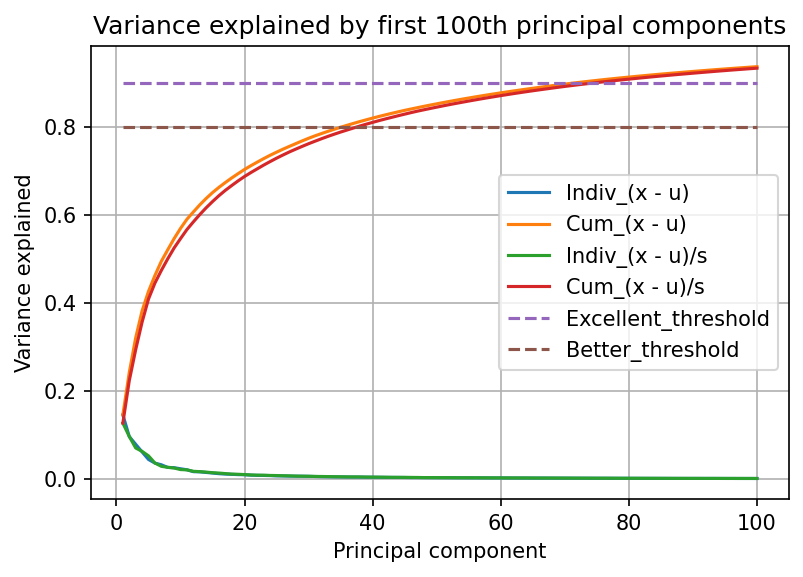

In [117]:
# Obtain the PCA solution  by calculate the SVD of Y
N_pca = 100 # how many components we want to choose to compress the images
'''Project (x - u) normalized images onto principal component space'''
U,S,V = linalg.svd(normal_imgs,full_matrices=False)
V = V.T
# Compute variance explained by principal components
rho = ((S*S) / (S*S).sum())[:N_pca]
# respresent (x - u) normalized images under the first 50th PCA scores
Z = normal_imgs @ V[:,:N_pca] 
display(HTML('<h2>PCA solution under (x - u) normalized images</h2>'))
print("V.shape",V[:,:N_pca] .shape)
print("normal_imgs.shape",normal_imgs.shape)
print("Z.shape",Z.shape)

'''Project (x - u)/s normalized images onto principal component space'''
U1,S1,V1 = linalg.svd(normal_std_imgs,full_matrices=False)
V1 = V1.T
# Compute variance explained by principal components
rho1 = ((S1*S1) / (S1*S1).sum())[:N_pca]
# respresent (x - u)/s normalized images under the first 50th PCA scores
Z1 = normal_std_imgs @ V1[:,:N_pca] 
display(HTML('<h2>PCA solution under (x - u)/s normalized images</h2>'))
print("V.shape",V1[:,:N_pca] .shape)
print("normal_std_imgs.shape",normal_std_imgs.shape)
print("Z.shape",Z1.shape)

threshold = 0.9
f = plt.figure() 
display(HTML(   '<h2>Show the difference between variance explained under the two normalization method</h2>' +
                '<p>Here we only plot the first ' + str(N_pca+1) + 'th main component'))

# Plot variance explained !!!Project (x - u) normalized images
plt.plot(range(1,len(rho)+1),rho,'-')                  # 绘制各在成分上投影的方差
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'-')       # 绘制各成分累加的可解释变异或课解释方差
# Plot variance explained !!!Project (x - u)/s normalized images
plt.plot(range(1,len(rho1)+1),rho1,'-')                  # 绘制各在成分上投影的方差
plt.plot(range(1,len(rho1)+1),np.cumsum(rho1),'-')       # 绘制各成分累加的可解释变异或课解释方差
# threshold
plt.plot([1,len(rho)],[threshold, threshold],'--')     # 绘制压缩要求阈值 0.9 A better one 
plt.plot([1,len(rho)],[0.8, 0.8],'--')                 # 绘制压缩要求阈值 0.8
plt.title('Variance explained by first '+ str(N_pca+1) +'th principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Indiv_(x - u)','Cum_(x - u)','Indiv_(x - u)/s','Cum_(x - u)/s','Excellent_threshold','Better_threshold'])
plt.grid()
plt.show()

## 5.c Visually inspect the first few PCA components as images. 
Do this by adding/subtracting the scaled PC that you want to inspect to the mean.